In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach
import bs4 as bs
import matplotlib as mpl
from scipy.stats import linregress


def plot_beach_ball(earthquake, m, ax, **kwargs):
    lon, lat = earthquake['coordinates']
    x, y = m(lon, lat)
    b = beach(earthquake['focal_mech'], xy=(x, y), **kwargs)
    b.set_zorder(10)
    ax.add_collection(b)
    
def parse_coords(c):
    c = c.replace('\t', '')
    c = c.replace('\n', '')
    c = c.strip()
    c = c.split(' ')
    c = [[float(co) for co in coord.split(',')] for coord in c]
    c = np.array([np.array(co) for co in c])
    return c

def rupture_length(magnitude):
    """
     $L(m) = 0.01 \times 10^{0.5m}$ (km) 
    """
    return 0.01 * 10 ** (0.5 * magnitude)

def shape_for_scatter_plot(bdf):
    bdf = bdf[bdf.n >= 50].copy()
    bdf['years before'] = bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20
    return bdf
  

In [2]:
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.3, 'name':'Kumamoto', 'focal_mech':[128  , 71 , -14]}
foreshock1 = {'focal_mech':[299, 79, -10], 'magnitude':6.5, 'coordinates':[130.808667, 32.741667]}
foreshock2 = {'focal_mech':[30, 77, 180], 'magnitude':6.4, 'coordinates':(130.777667, 32.700667)}

In [6]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])
eq = kumamoto

# rupture_length = rupture_length(7.3)

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=3*rupture_length(7.3), m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

# soup = bs.BeautifulSoup(open('/home/max/research/kumamoto/data/kyushu_fault.kml'), 'lxml')
# fault_coordinates = [parse_coords(tag.text) for tag in soup.findAll('coordinates')]

# SLIDING TIME WINDOW

* ADD - radius 5km and radius 30km calculation to b over t
* ADD - radius 5km and 30km to FMD plots with same color
* ADD - legend to b over t
* ADD - legend to fmds

In [10]:
time_window_centers = pd.date_range('01-01-1991', eq['time'], freq='6m')

In [13]:
window_sizes = (50, 100, 250, 1000)
radii = np.arange(5, rupture_length(7.3) * 2, 1)



In [16]:
def calculate_b_for_r_time_window(params):
    r, timewindow, half_window_size = params
    df_window = df_regional[df_regional.distance <= r].sort_index()
    time_window_ix = df_window.index.get_loc(timewindow, method='pad')
    
    lower_ix = time_window_ix - half_window_size
    if lower_ix < 0: lower_ix = 0
    upper_ix = time_window_ix + half_window_size
    
    df_window = df_window.iloc[lower_ix : upper_ix]
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_window.mag)
    return r, timewindow, half_window_size, a, b, bstd, n, mc

In [17]:
radii = np.arange(5, 2. * rupture_length(7.3))
timii = pd.date_range('01-01-1991', kumamoto['time'], freq='2m')
half_window_sizes = [50, 125, 250, 500]

parameters = [x for x in product(*[radii, timii, half_window_sizes])]
len(parameters)

51680

In [18]:
ix = df_regional[df_regional.distance <= 10].index.get_loc('01-01-1995', method='pad')

# df_regional.loc[ix]
df_regional.iloc[ix.start-500 : ix.start+25].shape

(0, 14)

In [19]:
from multiprocessing import Pool
pool = Pool()


# radii = np.arange(5, (rupture_length * 1.5) + 1, 1)
# timii = pd.date_range(start='01-01-1990', end=eq['time'], freq='1M')
# parameters = [x for x in product(radii, timii)]

results = pool.map(calculate_b_for_r_time_window, parameters)
pool.close()

In [20]:
results[0]

(5.0,
 Timestamp('1991-01-31 00:00:00', freq='2M'),
 50,
 2.8286083448557973,
 0.76192014368991567,
 0.26012639578575858,
 10,
 2.3000000000000003)

In [21]:
bt_df = pd.DataFrame(results, columns=['r', 't', 'half_window', 'a', 'b', 'bstd', 'n', 'mc'])

In [22]:
rupture_length(7.3)/2

22.334179607548155

# b over t example

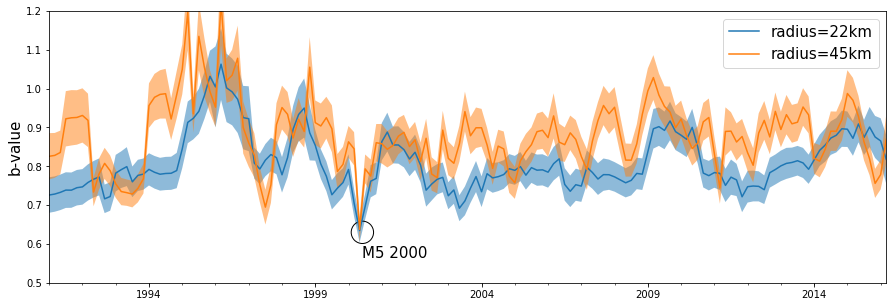

In [23]:
data1 = bt_df[(bt_df.r==22) & (bt_df.half_window==250)].set_index('t')
data2 = bt_df[(bt_df.r==45) & (bt_df.half_window==250)].set_index('t')

fig, ax = plt.subplots(figsize=(15, 5))

data1.b.plot(ax=ax, label='radius=22km')
data2.b.plot(ax=ax, label='radius=45km')

ax.fill_between(data1.index, data1.b-data1.bstd, data1.b+data1.bstd, alpha=0.5)
ax.fill_between(data2.index, data2.b-data2.bstd, data2.b+data2.bstd, alpha=0.5)


ax.legend(fontsize=15)

ax.set_ylim(0.5, 1.2)
ax.set_ylabel('b-value', fontsize=15)

x = pd.to_datetime('2000-06-08 00:32:46.129979')
ax.scatter(x=x, y=0.63, s=500, edgecolor='black', color='None')
ax.text(s='M5 2000', x=x, y=0.565, fontsize=15)

ax.set_xlabel('')

fig.savefig('/home/max/Dropbox/Saves/v0003/b_over_t_example.pdf', bbox_inches='tight', dpi=300)

In [24]:
df_regional[df_regional.decimal_year.between(2000, 2001) & (df_regional.mag>=5)]

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err,distance
timestamp,,,,,,,,,,,,,,
2000-06-08 00:32:46.129979,130.762,32.692333,2000.434488,6.0,8.0,5.0,10.31,0.0,32.0,46.130001,0.466253,0.84,NaN,6.912982


# b paramester sweep

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


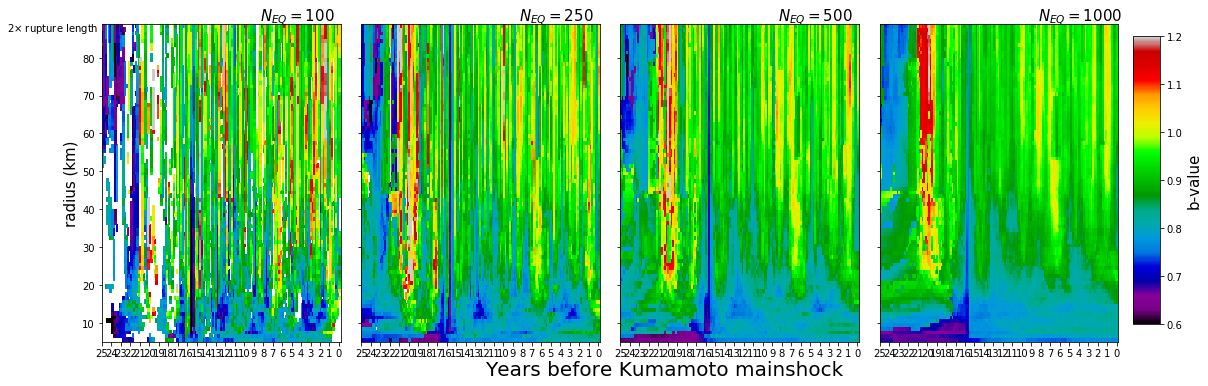

In [25]:
windows = (50, 125, 250, 500)
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)

for w, ax in zip(windows, axes):
    zi = bt_df[(bt_df['half_window']==w) & (bt_df.n >= 50)].pivot_table(index='t', columns='r', values='b',)
    yi = zi.columns
    xi = np.arange(zi.index.shape[0])
    xi_label = [np.datetime64(z, 'Y').astype(int) for z in zi.index]
    x, y = np.meshgrid(xi, yi)
    z = np.ma.masked_invalid(zi)
    cbar = ax.pcolormesh(x, y, z.transpose(), vmin=0.5, vmax=1.2, cmap='nipy_spectral')
# fig.colorbar(cbar, label='b-value')
# ax.invert_xaxis()
# xi_ticks = [i for i, j in  enumerate(replace_unique_items(xi_label)) if j is not None]
# xi_labels = [j for i, j in  enumerate(replace_unique_items(xi_label)) if j is not None]

# ax.set_xticks(xi_ticks)
# ax.set_xticklabels(xi_labels, rotation=90)
# ax.set_xticks(np.arange(zi.index))

# ax.set_xlabel('years before mainshock')
# ax.set_ylabel('radius (km)')

ax.set_xticks(np.arange(len(xi_label))[::6])
ax.set_xticklabels([abs(x - 46) for x in xi_label][::6])

# ax.text(s=r'$N_{EQ}=$', x=105, y=90, fontsize=15)

ax5 = fig.add_axes([1.0, 0.125, 0.025, .8])
cmap = mpl.cm.nipy_spectral
norm = mpl.colors.Normalize(vmin=0.6, vmax=1.2)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('b-value', fontsize=15)

axes[0].set_ylabel('radius (km)', fontsize=15)

axes[0].text(s=r'2$\times$ rupture length', x=-60, y=87)

fig.text(0.4, 0.0, 'Years before Kumamoto mainshock', va='center', rotation='horizontal', fontsize=20)

axes[0].text(s=r'$N_{EQ}=100$', x=100, y=90, fontsize=15)
axes[1].text(s=r'$N_{EQ}=250$', x=100, y=90, fontsize=15)
axes[2].text(s=r'$N_{EQ}=500$', x=100, y=90, fontsize=15)
axes[3].text(s=r'$N_{EQ}=1000$', x=100, y=90, fontsize=15)

fig.tight_layout()

fig.savefig('/home/max/Dropbox/Saves/v0003/b_over_t_params.pdf', bbox_inches='tight', dpi=300)

# b(t) vs r

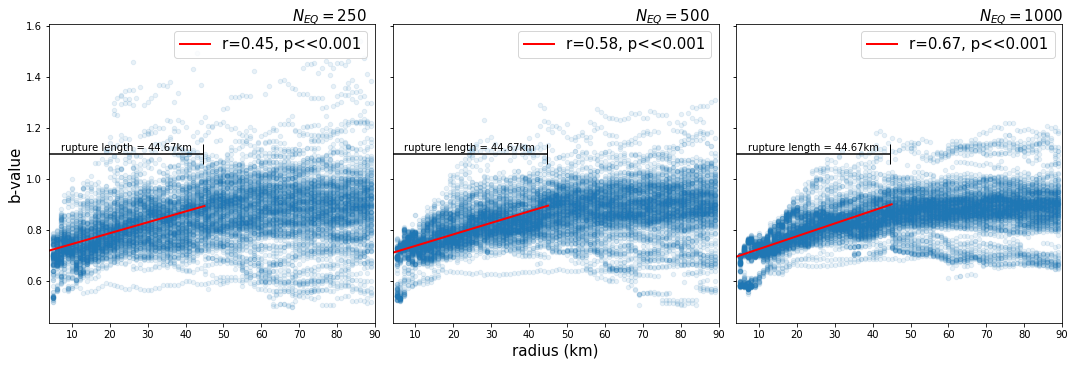

In [26]:
# fig, ax = plt.subplots()
RL = rupture_length(7.3)

data = bt_df[bt_df.n >= 50]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

data[data.half_window==125].plot(kind='scatter', x='r', y='b', alpha=0.1, ax=axes[0])
data[data.half_window==250].plot(kind='scatter', x='r', y='b', alpha=0.1, ax=axes[1])
data[data.half_window==500].plot(kind='scatter', x='r', y='b', alpha=0.1, ax=axes[2])

for ax in axes:
    ax.plot( [0, RL],[1.1, 1.1], marker='|', markersize=20, color='black')
    ax.text(s='rupture length = {r}km'.format(r=round(RL,2)), x=7, y=1.11)

axes[0].set_ylabel('b-value', fontsize=15)
axes[0].set_xlabel('')
axes[1].set_xlabel('radius (km)', fontsize=15)
axes[2].set_xlabel('')

x = 68
y = 1.62
axes[0].text(s=r'$N_{EQ}=250$', x=x, y=y, fontsize=15)
axes[1].text(s=r'$N_{EQ}=500$', x=x, y=y, fontsize=15)
axes[2].text(s=r'$N_{EQ}=1000$', x=x, y=y, fontsize=15)

def LR_here(windowsize, ax):
    LR_data = data[(data.half_window==windowsize) & (data.r <= RL)]
    LR = linregress(LR_data.r, LR_data.b)
    x = np.arange(0, RL+1, 1)
    y = LR.intercept + LR.slope * x
    ax.plot(x, y, color='red', linewidth=2, label='r={r}, p<<0.001'.format(r=LR.rvalue.round(2)))
    ax.legend(loc='upper right', fontsize=15)
    
LR_here(125, axes[0])
LR_here(250, axes[1])
LR_here(500, axes[2])

axes[0].set_xlim(4, 90)


fig.tight_layout()

fig.savefig('/home/max/Dropbox/Saves/v0003/b_over_t_vs_r_kuma.pdf', bbox_inches='tight', dpi=300)

In [48]:
data.corr()

,r,half_window,a,b,bstd,n,mc
r,1.000000,0.002237,0.115675,0.400495,0.145509,0.006049,0.045492
half_window,0.002237,1.000000,0.767194,-0.007016,-0.728536,0.935851,0.057446
a,0.115675,0.767194,1.000000,0.216954,-0.524915,0.618035,0.560351
b,0.400495,-0.007016,0.216954,1.000000,0.470598,-0.052533,-0.028480
bstd,0.145509,-0.728536,-0.524915,0.470598,1.000000,-0.751176,0.026471
n,0.006049,0.935851,0.618035,-0.052533,-0.751176,1.000000,-0.172742
mc,0.045492,0.057446,0.560351,-0.028480,0.026471,-0.172742,1.000000


LinregressResult(slope=-2.9797412264094373e-05, intercept=0.85368719619740463, rvalue=-0.052533370964643368, pvalue=5.9270779909251866e-31, stderr=2.5738660650927345e-06)

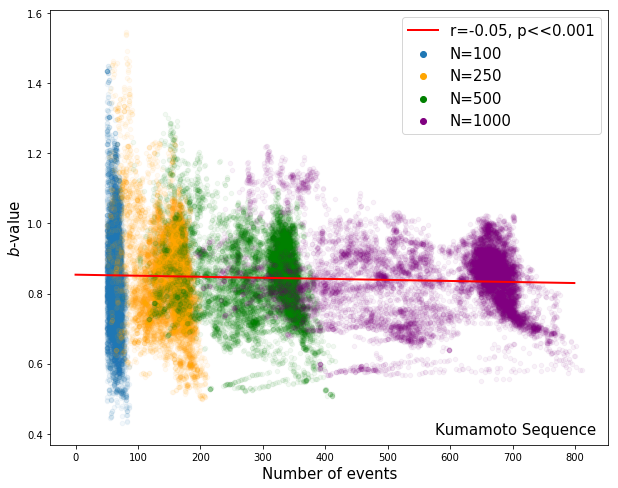

In [74]:
fig, ax = plt.subplots( figsize=(10, 8), sharex=True, sharey=True)

data[data.half_window==50].plot(ax=ax, kind='scatter', x='n' ,y='b', alpha=0.05, label=None)
data[data.half_window==125].plot(ax=ax, kind='scatter', x='n' ,y='b', color='orange', alpha=0.05, label=None)
data[data.half_window==250].plot(ax=ax, kind='scatter', x='n' ,y='b', color='green', alpha=0.05, label=None)
data[data.half_window==500].plot(ax=ax, kind='scatter', x='n' ,y='b', color='purple', alpha=0.05, label=None)

ax.scatter([],[], label='N=100')
ax.scatter([],[], label='N=250', color='orange')
ax.scatter([],[], label='N=500', color='green')
ax.scatter([],[], label='N=1000', color='purple')

LR = linregress(data.n, data.b)

x = np.arange(0, 800, 1)
y = LR.intercept + LR.slope * x

ax.plot(x, y, color='red', linewidth=2, label='r={r}, p<<0.001'.format(r=LR.rvalue.round(2)))

ax.legend(fontsize=15)

ax.set_ylabel('$b$-value', fontsize=15)
ax.set_xlabel('Number of events', fontsize=15)
ax.text(s='Kumamoto Sequence', x=575, y=0.4, fontsize=15)

fig.savefig('/home/max/Dropbox/Saves/v0003/radius_vs_n_sliding_kuma_supplemental.pdf', bbox_inches='tight')
LR